In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill
import pandas as pd
import plotly.express as ply_exp
import plotly.graph_objects as ply_go

# Importando os módulos contendo as funções criadas no projeto

from aux_train import *
from aux_plot import *
import API_Numpy
import API_TensorFlow

float_pres = 'float64' # Definindo a precisão padrão para as análises

In [2]:
nomes = [
    "WENO-JS"     , "WENO-Z"      , "WENO-Z+"     , 
    "WENO-JS (M)" , "WENO-Z (M)"  , "WENO-Z+ (M)" , 
    "WENO-JS (MS)", "WENO-Z (MS)" , "WENO-Z+ (MS)", 
    "WENO-JS (BI)", "WENO-Z (BI)" , "WENO-Z+ (BI)",
    "WENO-ZC (M)" , "WENO-ZC (MS)", "WENO-ZC (BI)"
]

API      = API_Numpy
equation = transp_equation

WENOs = {}
WENOs[nomes[ 1]] = simulation(API, equation, WENO_Z , mapping =     null_mapping, map_function = None).Sim

Weights = {}
Weights[nomes[ 0]] = simulation(API, equation, WENO_JS, mapping =     null_mapping, map_function = None).Get_weights
Weights[nomes[ 1]] = simulation(API, equation, WENO_Z , mapping =     null_mapping, map_function = None).Get_weights
Weights[nomes[ 2]] = simulation(API, equation, WENO_Zp, mapping =     null_mapping, map_function = None).Get_weights
Weights[nomes[ 3]] = simulation(API, equation, WENO_JS, mapping =     post_mapping, map_function = Henrick_mapping).Get_weights
Weights[nomes[ 4]] = simulation(API, equation, WENO_Z , mapping =     post_mapping, map_function = Henrick_mapping).Get_weights
Weights[nomes[ 5]] = simulation(API, equation, WENO_Zp, mapping =     post_mapping, map_function = Henrick_mapping).Get_weights
Weights[nomes[ 6]] = simulation(API, equation, WENO_JS, mapping =      pre_mapping, map_function = Hong_mapping).Get_weights
Weights[nomes[ 7]] = simulation(API, equation, WENO_Z , mapping =      pre_mapping, map_function = Hong_mapping).Get_weights
Weights[nomes[ 8]] = simulation(API, equation, WENO_Zp, mapping =      pre_mapping, map_function = Hong_mapping).Get_weights
Weights[nomes[ 9]] = simulation(API, equation, WENO_JS, mapping =      pre_mapping, map_function = BI_mapping).Get_weights
Weights[nomes[10]] = simulation(API, equation, WENO_Z , mapping =      pre_mapping, map_function = BI_mapping).Get_weights
Weights[nomes[11]] = simulation(API, equation, WENO_Zp, mapping =      pre_mapping, map_function = BI_mapping).Get_weights
Weights[nomes[12]] = simulation(API, equation, WENO_ZC, mapping = post_inv_mapping, map_function = Henrick_mapping).Get_weights
Weights[nomes[13]] = simulation(API, equation, WENO_ZC, mapping =  pre_inv_mapping, map_function = Hong_mapping).Get_weights
Weights[nomes[14]] = simulation(API, equation, WENO_ZC, mapping =  pre_inv_mapping, map_function = BI_mapping).Get_weights

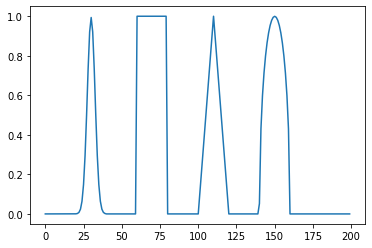

In [3]:
Δx = 0.01

# f_test = lambda x: np.where(x > 0.5, 0.0, 1.0)*np.where(x < -0.5, 0.0, 1.0)

def f_test(x):
    z = tf.constant(-0.7, dtype=float_pres)
    δ = tf.constant(0.005, dtype=float_pres)
    β = tf.math.log(tf.constant(2.0, dtype=float_pres))/(36.0*(δ**2.0))
    a = tf.constant(0.5, dtype=float_pres)
    α = tf.constant(10, dtype=float_pres)
    
    def G(x, β, z):
        return tf.math.exp(-β*(x-z)**2)
    
    def F(x, α, a):
        return tf.math.sqrt(tf.math.maximum(1-(α**2)*((x-a)**2),0))
    
    f1 = (G(x, β, z-δ) + 4*G(x, β, z) + G(x, β, z+δ))/6 # x in [-0.8, -0.6]
    f2 = 1                                              # x in [-0.4, -0.2]
    f3 = 1-tf.math.abs(10*(x-0.1))                      # x in [ 0.0,  0.2]
    f4 = (F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))/6 # x in [ 0.4,  0.6]
    f5 = 0                                              # otherwise
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.8),
        tf.math.less_equal(x, -0.6)
    )
    f1 = f1*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.4),
        tf.math.less_equal(x, -0.2)
    )
    f2 = f2*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.0),
        tf.math.less_equal(x, 0.2)
    )
    f3 = f3*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.4),
        tf.math.less_equal(x, 0.6)
    )
    f4 = f4*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    f = f1 + f2 + f3 + f4 + f5
    
    return f

plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [23]:
t_final  = 2
n        = 400
CFL      = 0.2
fator    = 10   # Quantas vezes menor é a malha para a solução de referência

fronteira = FronteiraPeriodica

Δx   = 2/n
x    = tf.range(-1, 1, Δx, dtype=float_pres)
soma = {}

for nome in nomes:
    soma[nome] = np.sum(Weights[nome](f_test(x), Δx, fronteira)[0], axis=1)
    print(nome+"              ")

n_ref  = n*fator
Δx_ref = 2/n_ref

WENO-JS              
WENO-Z              
WENO-Z+              
WENO-JS (M)              
WENO-Z (M)              
WENO-Z+ (M)              
WENO-JS (MS)              
WENO-Z (MS)              
WENO-Z+ (MS)              
WENO-JS (BI)              
WENO-Z (BI)              
WENO-Z+ (BI)              
WENO-ZC (M)              
WENO-ZC (MS)              
WENO-ZC (BI)              


In [24]:
x     = tf.range(-1, 1, Δx, dtype=float_pres)
y     = soma[nomes[0]]
label = tf.repeat([nomes[0]], [len(soma[nomes[0]])])

for j in range(1, len(nomes)):
    x     = tf.concat([    x, tf.range(-1, 1, Δx, dtype=float_pres)], axis = 0)
    y     = tf.concat([    y, soma[nomes[j]]], axis = 0)
    label = tf.concat([label, tf.repeat([nomes[j]], [len(soma[nomes[j]])])], axis = 0)

df = pd.DataFrame(
    {
        "x"     : x     ,
        "y"     : y  ,
        "label" : label
    }
)

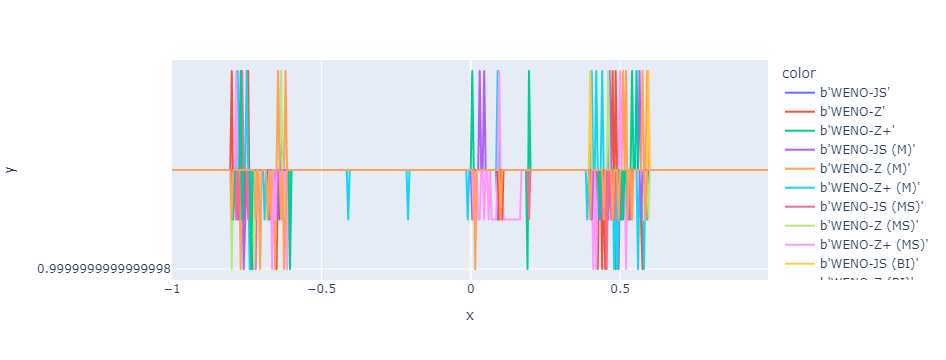

In [26]:
fig = ply_exp.line(
    data_frame = df,
    x          = x             ,
    y          = y,
    color      = label,
    log_y      = True
)
# fig.add_trace(
#     ply_go.Scatter(
#         x    = tf.range(-1, 1, Δx_ref, dtype=float_pres)         ,
#         y    = tf.range(-1, 1, Δx_ref, dtype=float_pres) , # u_ref, 
#         mode = "lines"                                           ,
#         line = ply_go.scatter.Line(color="#666666")              ,
#         name = "Função",
#     )
# )
fig.update_yaxes(exponentformat="power")
fig.show()

In [ ]:
# fig.write_html("htmls/formas peso omega " + str(i) + " (T=0).html")

In [27]:
t_final  = 2
n        = 400
CFL      = 0.2
fator    = 10   # Quantas vezes menor é a malha para a solução de referência

fronteira = FronteiraPeriodica

Δx   = 2/n
x    = tf.range(-1, 1, Δx, dtype=float_pres)
u     = WENOs["WENO-Z"](f_test(x), t_final, Δx, CFL, fronteira)

soma = {}

for nome in nomes:
    soma[nome] = np.sum(Weights[nome](u, Δx, fronteira)[0], axis=1)
    print(nome+"              ")

n_ref  = n*fator
Δx_ref = 2/n_ref

WENO-JS              
WENO-Z              
WENO-Z+              
WENO-JS (M)              
WENO-Z (M)              
WENO-Z+ (M)              
WENO-JS (MS)              
WENO-Z (MS)              
WENO-Z+ (MS)              
WENO-JS (BI)              
WENO-Z (BI)              
WENO-Z+ (BI)              
WENO-ZC (M)              
WENO-ZC (MS)              
WENO-ZC (BI)              


In [28]:
x     = tf.range(-1, 1, Δx, dtype=float_pres)
y     = soma[nomes[0]]
label = tf.repeat([nomes[0]], [len(soma[nomes[0]])])

for j in range(1, len(nomes)):
    x     = tf.concat([    x, tf.range(-1, 1, Δx, dtype=float_pres)], axis = 0)
    y     = tf.concat([    y, soma[nomes[j]]], axis = 0)
    label = tf.concat([label, tf.repeat([nomes[j]], [len(soma[nomes[j]])])], axis = 0)

df = pd.DataFrame(
    {
        "x"     : x     ,
        "y"     : y  ,
        "label" : label
    }
)

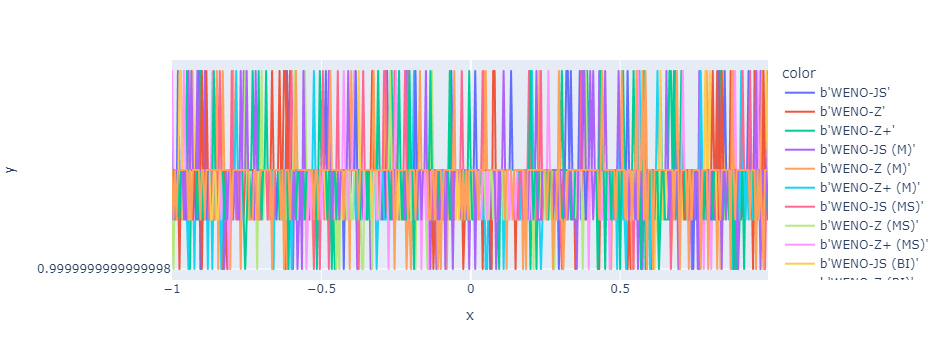

In [29]:
fig = ply_exp.line(
    data_frame = df,
    x          = x             ,
    y          = y,
    color      = label,
    log_y      = True
)
# fig.add_trace(
#     ply_go.Scatter(
#         x    = tf.range(-1, 1, Δx_ref, dtype=float_pres)         ,
#         y    = tf.range(-1, 1, Δx_ref, dtype=float_pres) , # u_ref, 
#         mode = "lines"                                           ,
#         line = ply_go.scatter.Line(color="#666666")              ,
#         name = "Função",
#     )
# )
fig.update_yaxes(exponentformat="power")
fig.show()